# Translation model from COCO -> MPII


In [2]:
import torch
import numpy as np
import torch.nn as nn
import copy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from lovely_numpy import lo
import scipy
import json

/datagrid/personal/baljibil/repos/env-vitpose/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:


ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/repos/scripts/data/mpii_train_gt.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/from_vitpose_plus/IMG-mpii_train-Rep-coco.json', 'r') as f:
    annot_pred_coco = json.load(f)

with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_val.json', 'r') as f:
    annot_truth_val_set = json.load(f)

with open(ROOT_FOLDER + '/repos/scripts/data/from_vitpose_plus/IMG-mpii_val-Rep-coco.json', 'r') as f:
    annot_pred_coco_val_set = json.load(f)

# with open(ROOT_FOLDER + '/repos/scripts/mpii_pred_on_mpii/pred.json', 'r') as f:
#     annot_pred_mpii = json.load(f)



In [4]:
X = list()
y = list()
box_scale = list()
box_center = list()
index2orig = list()

print("len: " , len(annot_truth))
for i in range(len(annot_truth)):
  # skip = False
  # for joint_vis in annot_truth[i]['joints_vis']:
  #   if joint_vis == 0:
  #     skip = True
  #     break
  # if skip:
  #   continue
  index2orig.append(i)
  X.append(annot_pred_coco['annotations'][i]['joints'])
  y.append(annot_truth[i]['joints'])
  box_scale.append(annot_truth[i]['scale'])
  box_center.append(annot_truth[i]['center'])
X = np.array(X)
y = np.array(y)
box_scale = np.array(box_scale)
box_center = np.array(box_center)
print("X shape: ", X.shape)
print("y shape:", y.shape)
print("box scale:", box_scale.shape)
print("box center:", box_center.shape)

len:  22246
X shape:  (22246, 17, 2)
y shape: (22246, 16, 2)
box scale: (22246,)
box center: (22246, 2)


In [5]:
lo(np.minimum(0, X))

array[22246, 17, 2] n=756364 (5.8Mb) x∈[-3.092e+05, 0.] μ=-0.812 σ=389.644

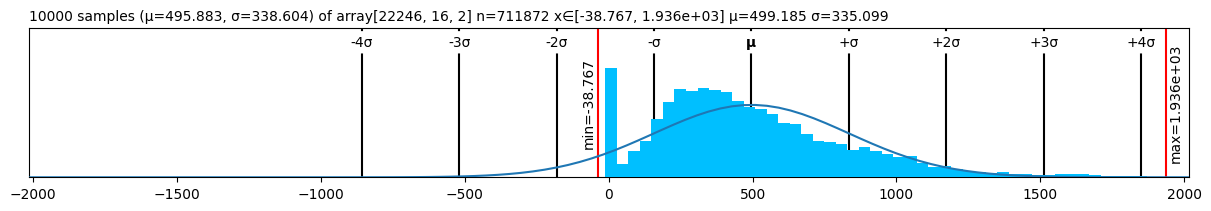

In [6]:
lo(y).plt

How many negative examples are there on each of those (negative doesn't mean anything, except for -1 for 1 where it's non-visible)

In [7]:
print((X < 0).sum())
print(((y < 0) & (y != -1)).sum())
negative_x_mask = np.any(X[:,:,0] <= 0, axis=1) | np.any(X[:,:,1] <= 0, axis=1)

X_clean = X[~negative_x_mask]
y_clean = y[~negative_x_mask]

negative_y_mask = np.any(
  (y_clean[:,:,0] <= 0) & (y_clean[:,:,0] != -1), axis=1
  ) | np.any((y_clean[:,:,1] <= 0) & (y_clean[:,:,1] != -1), axis=1)
X_clean = X_clean[~negative_y_mask]
y_clean = y_clean[~negative_y_mask]

box_scale_clean = box_scale[~negative_x_mask]
box_scale_clean = box_scale_clean[~negative_y_mask]

box_center_clean = box_center[~negative_x_mask]
box_center_clean = box_center_clean[~negative_y_mask]

print(X_clean.shape)
print(y_clean.shape)


1150
325
(21171, 17, 2)
(21171, 16, 2)


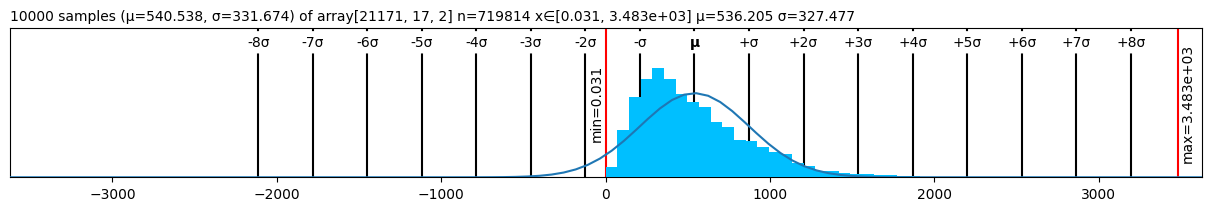

In [8]:
lo(X_clean).plt

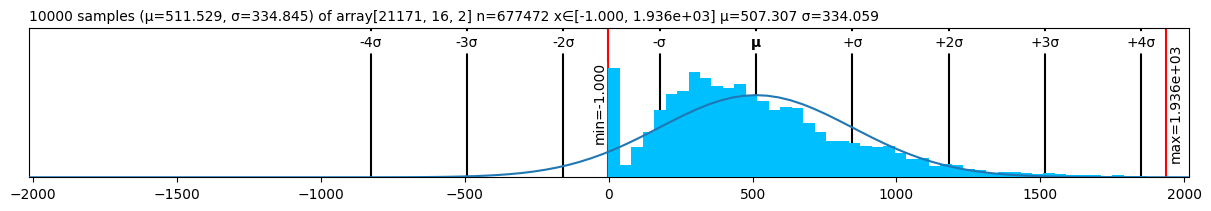

In [9]:
lo(y_clean).plt

## Normalize the dataset
- First by scale value of the bounding box
- Then either 0-1 normalization

In [10]:
# box_scale = N x 1
# box_center = N x 2
# N x 16 x 2

# needs masking on normalization as well
# to not use not joint visible points
def unnormalize(data, box_center, box_scale, scale_px=200*1.25, mask = None):
  data = copy.deepcopy(data)

  bbox_left = box_center - ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_right = box_center + ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_width = bbox_right - bbox_left

  data *= bbox_width[:, np.newaxis, :]
  data += bbox_left[:, np.newaxis, :]
  if isinstance(mask, np.ndarray):
    data = data * mask
    # To make back to -1
    data = data + (-1) * (1 - mask)

  return data

def normalize(data, box_center, box_scale, scale_px=200*1.25, mask = None):
  # first width & height, but they are the same
  data = copy.deepcopy(data)
  # bbleft point N x 2
  bbox_left = box_center - ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_right = box_center + ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_width = bbox_right - bbox_left

  data -= bbox_left[:, np.newaxis, :] 
  data /= bbox_width[:, np.newaxis, :]
 
  if isinstance(mask, np.ndarray):
      data = data * mask
      # To make back to -1
      data = data + (-1) * (1 - mask)
  return data
  # bbright point
  # return data
X_normalized = normalize(X_clean, box_center=box_center_clean, box_scale=box_scale_clean)
y_normalized = normalize(y_clean, box_center=box_center_clean, box_scale=box_scale_clean, mask=(y_clean != -1))
lo(y_normalized)

array[21171, 16, 2] n=677472 (5.2Mb) x∈[-1.159, 1.230] μ=0.411 σ=0.383

In [41]:
# Check normalize and unnormalize
print((y == unnormalize(normalize(y, box_center=box_center, box_scale=box_scale, mask=(y != -1)), 
                        box_center=box_center, box_scale=box_scale, mask=(y != -1))).sum() != 0)
identity = unnormalize(normalize(y, box_center=box_center, box_scale=box_scale, mask=(y != -1)), 
                        box_center=box_center, box_scale=box_scale, mask=(y != -1))
print((identity - y).sum())


True
-1.646778546859906e-11


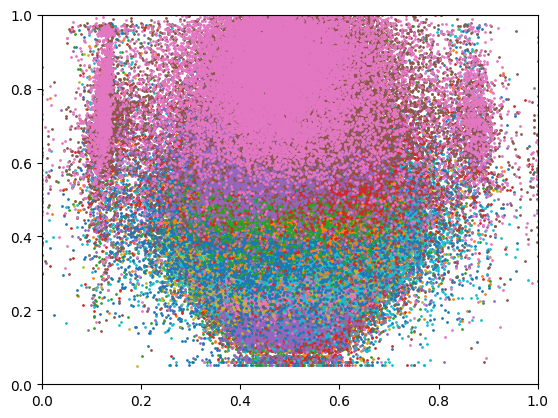

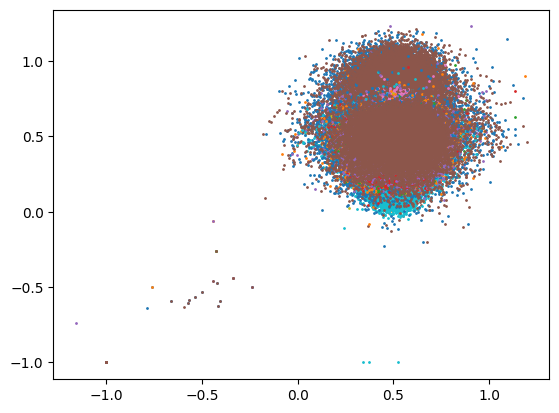

In [12]:
plt.xlim([0,1])
plt.ylim([0,1])

for i in range(17):
  plt.scatter(X_normalized[:, i, 0],X_normalized[:, i, 1], s=1)
plt.show()

for i in range(16):
  plt.scatter(y_normalized[:, i, 0],y_normalized[:, i, 1], s=1)
plt.show()

### Clean normalized

In [13]:
negative_x_mask = np.any(X_normalized[:,:,0] <= 0, axis=1) | np.any(X_normalized[:,:,1] <= 0, axis=1
                        ) | np.any(X_normalized[:,:,0] >= 0.95, axis=1
                        ) | np.any(X_normalized[:,:,1] >= 1.05, axis=1)

X_clean = X_normalized[~negative_x_mask]
y_clean = y_normalized[~negative_x_mask]

negative_y_mask = np.any(
  (y_clean[:,:,0] <= 0) & (y_clean[:,:,0] != -1), axis=1
  ) | np.any((y_clean[:,:,1] <= 0) & (y_clean[:,:,1] != -1), axis=1
  ) | np.any(y_clean[:,:,0] >= 0.95, axis=1
  ) | np.any(y_clean[:,:,1] >= 1.05, axis=1)


X_clean = X_clean[~negative_y_mask]
y_clean = y_clean[~negative_y_mask]

box_scale_clean = box_scale_clean[~negative_x_mask]
box_scale_clean = box_scale_clean[~negative_y_mask]

box_center_clean = box_center_clean[~negative_x_mask]
box_center_clean = box_center_clean[~negative_y_mask]

print(X_clean.shape)
print(y_clean.shape)
X_normalized = X_clean
y_normalized = y_clean


(20060, 17, 2)
(20060, 16, 2)


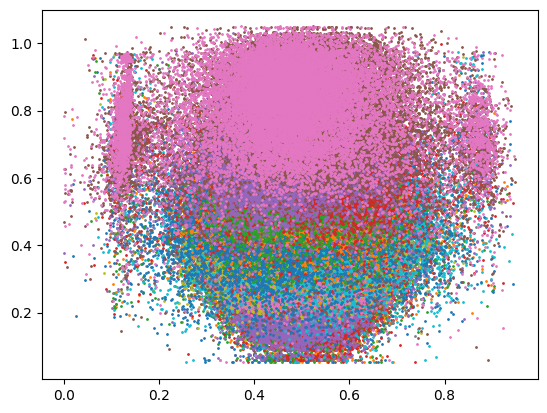

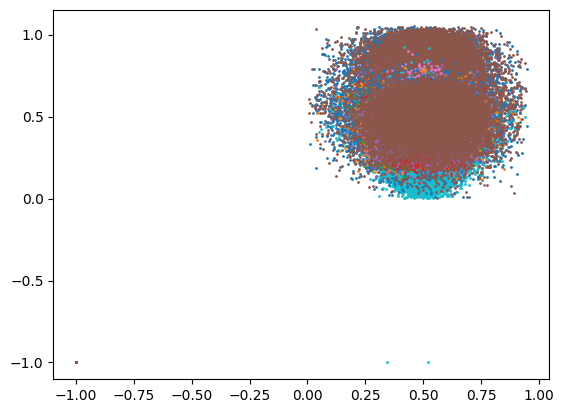

In [14]:
for i in range(17):
  plt.scatter(X_normalized[:, i, 0],X_normalized[:, i, 1], s=1)
plt.show()

for i in range(16):
  plt.scatter(y_normalized[:, i, 0],y_normalized[:, i, 1], s=1)
plt.show()

### Display outliers in normalized env

array[20060, 17, 2] n=682040 (5.2Mb) x∈[0.000, 1.050] μ=0.491 σ=0.162


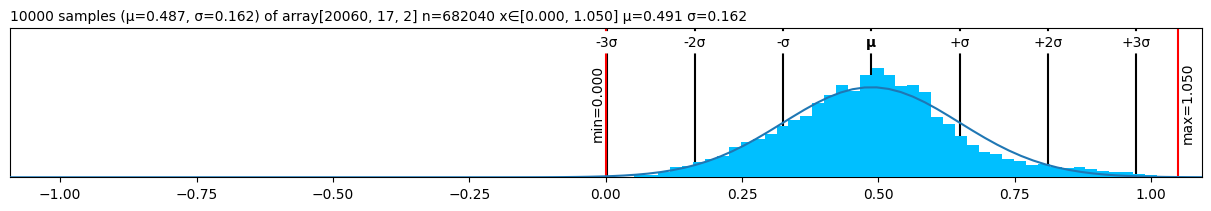

In [15]:
print(lo(X_normalized))
lo(X_normalized).plt

array[20060, 16, 2] n=641920 (4.9Mb) x∈[-1.000, 1.050] μ=0.407 σ=0.387


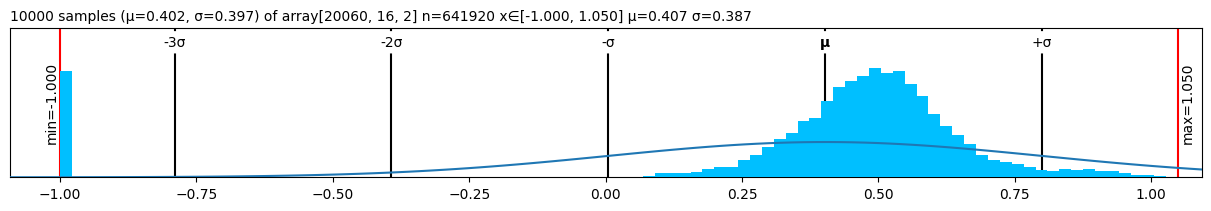

In [16]:
print(lo(y_normalized))
lo(y_normalized).plt

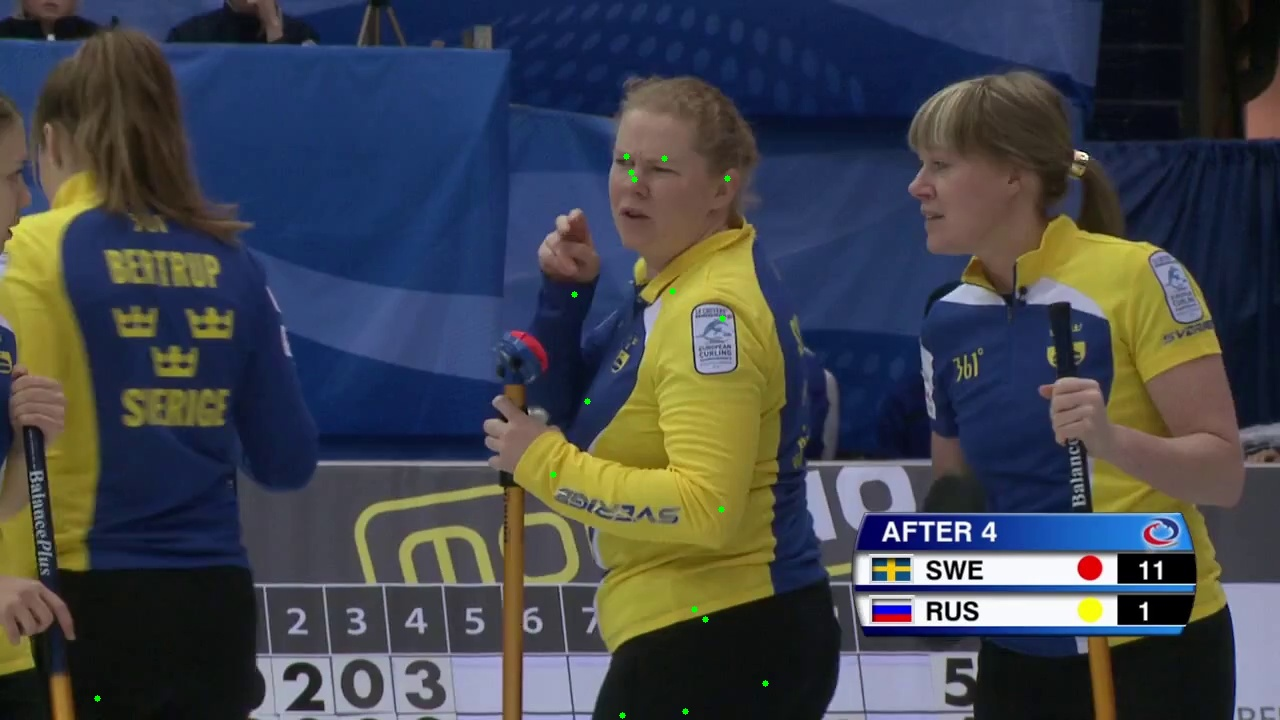

In [17]:
ROOT_FOLDER = "/datagrid/personal/baljibil"

# from utils import display_kp_image
from IPython.display import Image, display
import cv2

outlier_index = np.argmin(y_normalized)
index = np.unravel_index(outlier_index, y_normalized.shape)

def display_kp_image(im_path, keypoints):

  image = cv2.imread(im_path)

  for kp in keypoints:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'images/tm_results/image_test0.jpg', image)

  display(Image(filename=f'images/tm_results/image_test0.jpg'))

display_kp_image(ROOT_FOLDER+'/data/MPII_COCO/images/'+annot_truth[index2orig[index[0]]]['image'],
                annot_pred_coco['annotations'][index2orig[index[0]]]['joints']
                 )

## Outlier images from coco prediction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


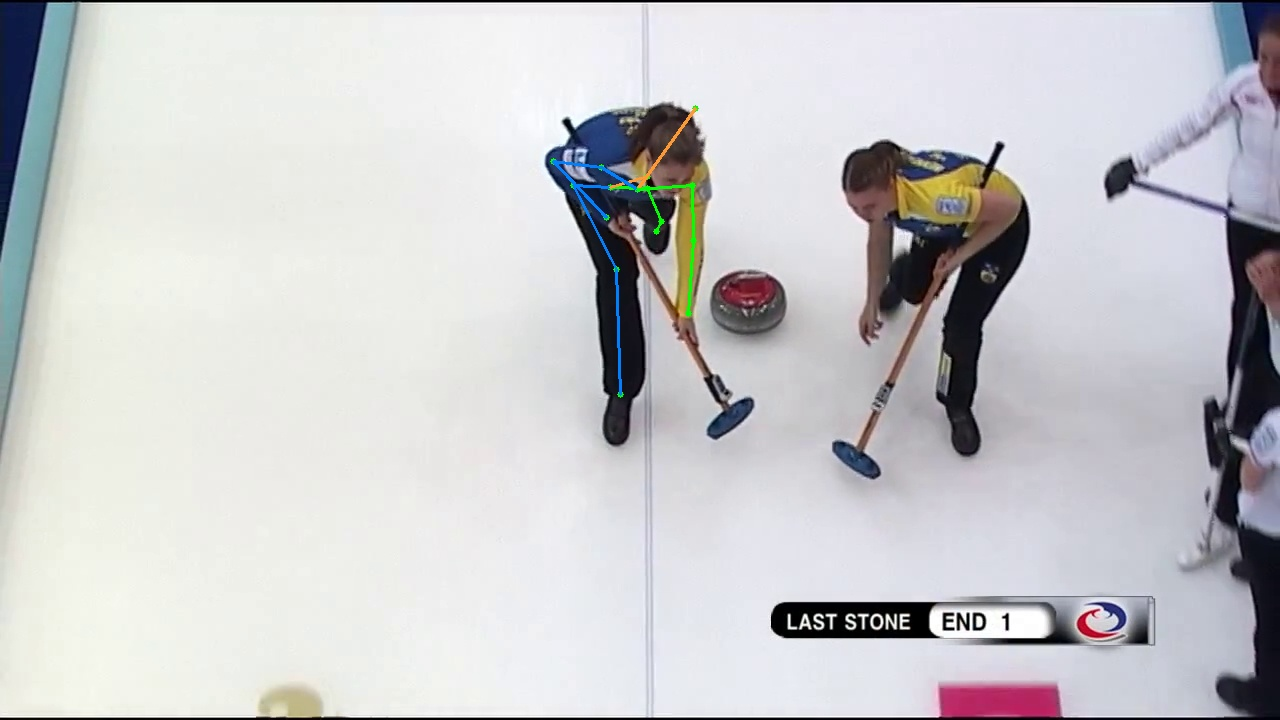

In [18]:
%load_ext autoreload
%autoreload 2

from visualize import visualize_with_keypoints, save_with_keypoints

visualize_with_keypoints(0, annot_truth, annot_truth[0]['joints'])

In [19]:
# N x 17 x 2
index = 0
count = 0
for row in range(y_normalized.shape[0]):
  
  for col in range(y_normalized.shape[1]):
    # Heads
      if y_normalized[row, col, 1] < 0 and y_normalized[row, col, 1] != -1:
        print("heree")
        save_with_keypoints(nth_image=row,
                           annot_truth=annot_truth, 
                           path = f'images/outliers/image{annot_truth[row]["image"]}',
                           keypoints=y[row],
                           skeleton=None,
                           bounding_box=(annot_truth[row]["center"],annot_truth[row]["scale"])
                           )
      index += 1  
# print("On the boundary: ", count)


# PCK Accuracy implementation

In [20]:
# Given prediction and ground truth with of Nx16x2, where N is sample num return PCKh score.
def calculatePCKh(predict, gt):
    # only gt has -1 values
    if torch.is_tensor(predict) and torch.is_tensor(gt):
        # Only use values that are defined
        _gt = gt
        _predict = predict

        mask = torch.all(gt[:, 8:10, 0] != -1, dim=1) 
        _predict = _predict[mask]
        _gt = _gt[mask]

        undefined_point_mask = _gt != -1
        _gt = _gt * undefined_point_mask
        _predict = _predict * undefined_point_mask

        distances = torch.norm((_gt - _predict), dim=-1)
        head_length = torch.norm((_gt[:, 8] - _gt[:, 9]), dim=-1) * 0.5 * 0.6
        # if head_length becomes 0, meaning, it's not defined
        # there'd be no distance lower than zero so still works
        # but we have to remove examples that has no head length
        correct_classified = distances <= head_length[:, None]
        correct_classified = torch.sum(correct_classified, dim=-1)
        total_keypoints = _gt.shape[0] * _gt.shape[1]
        percentage = correct_classified.sum() / total_keypoints
        return percentage.item()

    else:
        _gt = gt
        _predict = predict

        no_head_mask = np.all(gt[:, 8:10, 0] != -1, axis=1) 
        _predict = _predict[no_head_mask]
        _gt = _gt[no_head_mask]
        
        undefined_point_mask = _gt != -1
        _gt = _gt * undefined_point_mask
        _predict = _predict * undefined_point_mask
        
        distances = np.linalg.norm((_gt - _predict), axis=-1)
        # if head_length becomes 0, meaning, it's not defined
        # there'd be no distance lower than zero so still works
        # but we have to remove examples that has no head length
        head_length = np.linalg.norm((_gt[:, 8] - _gt[:, 9]), axis=-1) * 0.5 * 0.6
        correct_classified = distances <= head_length[:, np.newaxis]
        correct_classified = np.sum(correct_classified, axis=-1)
        total_keypoints = _gt.shape[0] * _gt.shape[1]
        percentage = correct_classified.sum() / (total_keypoints)
    return percentage


calculatePCKh(y_normalized, y_normalized)

1.0

## Define baseline accuracy

In [21]:
# Fake X identity base/ Direct COCO->MPII
def handcraft(coco_x, mpii_y):
  mapping =  {0:16, 1:14, 5: 15, 4: 13, 2:12, 3:11, 15: 9, 14:7, 13: 5, 10:10, 11:8, 12:6}
  # Mergeable points merge
  X_mpii_identity = np.ones_like(mpii_y)
  # Merge-able points
  for mpii_key, coco_key in mapping.items():
    X_mpii_identity[:,mpii_key] = coco_x[:,coco_key]
  # pelvis (To define baseline, pelvis is almost in the middle of left and right hip)
  X_mpii_identity[:,6] = (X_mpii_identity[:,2]+X_mpii_identity[:,3])/2
  # thorax (To define baseline, thorax is almost in the middle of left and right shoulder)
  X_mpii_identity[:,7] = (X_mpii_identity[:,12]+X_mpii_identity[:,13])/2
  X_mpii_identity[:,8] = (X_mpii_identity[:,7]+coco_x[:,0])/2
  X_mpii_identity[:,9] = (coco_x[:, 1] + coco_x[:, 2] ) / 2
  return X_mpii_identity

X_transformed_normalized = handcraft(X_normalized, y_normalized)
print(calculatePCKh(X_transformed_normalized, y_normalized))


0.8827005461469085


## Split train, val, test

In [22]:
from sklearn.model_selection import train_test_split
from torchvision import transforms

X_train, X_val, y_train, y_val = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

# Create a DataLoader for training and validation data
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)



train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=64)


Train instance:  16048
Val instance:  4012
torch.Size([16048, 17, 2])
torch.Size([16048, 16, 2])
torch.Size([4012, 17, 2])
torch.Size([4012, 16, 2])


### Definition of augmentations

In [23]:
def random_shift(data , p=0.1, shift_constant=0.3):
  # N x 16 x 2
  if torch.rand(1).item() < p:
    data = copy.deepcopy(data)
    # random_batch_n = torch.randint(0, data.shape[0], (1, )).item()
    random_point = torch.randint(0, 16, (1, )).item()

    # random number between -0.15 to 0.15
    # to choose from gaussian distrubution
    random_shift_x = torch.randn(1).item() * shift_constant
    random_shift_y = torch.randn(1).item() * shift_constant

    data[:, random_point, 0] += random_shift_x
    data[:, random_point, 1] += random_shift_y
    return data
  
  return data

# swap_points = [(0,5), (1,4), (2,3), (10,15), (11,14), (12,13)]
def horizontal_flip(data_x, data_y, p=0.1):
  if torch.rand(1).item() < p:
    data_x = copy.deepcopy(data_x)
    data_y = copy.deepcopy(data_y)
    data_x[:,:,0] = 1 - data_x[:,:,0]
    data_y[:,:,0] = 1 - data_y[:,:,0]
    return data_x, data_y
  return data_x, data_y



In [32]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

class TranslatorNN(nn.Module):
    def __init__(self):
        super().__init__()
 
        self.layers = nn.Sequential(nn.Flatten(),
                                     nn.Linear(2*17,512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 2*16)
                                     )
    def forward(self, x):
        x = self.layers(x)
        return x.view(-1, 16, 2)

def init_model():
    return TranslatorNN().to(device)

In [39]:
def train_model(model, lr=0.01, max_epoch=100, logs=[]):
    criterion = nn.L1Loss()
    optimizer = optim.SGD(model.parameters(), lr=lr, nesterov=True, momentum=0.9)
    best_epoch = 0
    best_val_loss = 10000000
    best_model = None
    best_accuracy = 0
    # Training loop
    for epoch in range(max_epoch):
        if epoch == 0:
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    outputs = model(inputs)
                    mask = targets != -1
                    loss = criterion(outputs * mask, targets * mask)
                    val_loss += loss.item() * inputs.size(0)
            val_epoch_loss = val_loss / len(val_dataset)
        
            print(f"Epoch [{epoch}/{max_epoch}], Val Loss: {val_epoch_loss:.6f}")
        model.train()
        running_loss = 0.0
        train_accuracy = 0.0
        for inputs, targets in train_loader:
            # Include data augmentation
            inputs = random_shift(inputs, p=0.2, shift_constant=0.1)   
            inputs,targets = horizontal_flip(inputs, targets, p=0.2)
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            mask = targets != -1
            loss = criterion(outputs * mask, targets * mask)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            with torch.no_grad():
                train_accuracy += (calculatePCKh(outputs, targets))

        epoch_loss = running_loss / len(train_dataset)
        train_accuracy = train_accuracy / (len(train_dataset) / train_loader.batch_size)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        val_size = 0
        accuracy = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                mask = targets != -1
                loss = criterion(outputs * mask, targets * mask)
                val_loss += loss.item() * inputs.size(0)
                val_size += inputs.size(0)
                accuracy += (calculatePCKh(outputs, targets))
        val_epoch_loss = val_loss / len(val_dataset)
        # Cuz batch size is 1?
        accuracy = accuracy / (len(val_dataset) / val_loader.batch_size)
        # For 16 keypoints
        if accuracy > best_accuracy:
            best_model = copy.deepcopy(model)
            best_epoch = epoch
            best_val_loss = val_loss
            best_accuracy = accuracy
        logs.append((epoch+1,epoch_loss, val_epoch_loss, accuracy))
        if (epoch+1) % 10 == 1:
            print(f"Epoch [{epoch+1}/{max_epoch}], Train Loss: {epoch_loss:.6f}, TAccuracy: {train_accuracy * 100:.2f}%,  Val Loss: {val_epoch_loss:.6f} Accuracy: {accuracy * 100:.2f}%")
    # model at best epoch
    return best_epoch, best_model, best_val_loss, best_accuracy



In [40]:
# learning_rates = [1, 0.1, 0.15, 0.5, 0.01, 0.03, 0.001, 0.003, 0.0001]
learning_rates = [1e-2]

# batch_size = [1,4,8,16,32,64]
epoch_max = [200]
param_comb = [{'lr':x, 'epoch':y} for x in learning_rates for y in epoch_max]
print(len(param_comb),param_comb)

best_model = None
best_loss = None
best_params = None
best_accuracy = 0
best_model_logs = []
torch.manual_seed(42)
for param in param_comb:
  print(f'Training for param: {param}')
  lr = param['lr']
  epoch = param['epoch']
  results_logs = []
  model = init_model()
  print(model)
  t_epoch, t_model, t_loss, t_accuracy = train_model(model,lr=lr,max_epoch=epoch,logs=results_logs)
  print(f'{param} -> {t_accuracy:.4f}')

  if t_accuracy > best_accuracy:
    best_model = copy.deepcopy(t_model)
    best_model_logs = copy.deepcopy(results_logs)
    best_loss = t_loss
    best_epoch = t_epoch
    best_params = param
    best_accuracy = t_accuracy
  



1 [{'lr': 0.01, 'epoch': 200}]
Training for param: {'lr': 0.01, 'epoch': 200}
TranslatorNN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=34, out_features=512, bias=True)
    (2): Tanh()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Tanh()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Tanh()
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): Tanh()
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): Tanh()
    (11): Linear(in_features=512, out_features=512, bias=True)
    (12): Tanh()
    (13): Linear(in_features=512, out_features=32, bias=True)
  )
)
Epoch [0/200], Val Loss: 0.469217
Epoch [1/200], Train Loss: 0.114712, TAccuracy: 14.86%,  Val Loss: 0.061718 Accuracy: 19.65%
Epoch [11/200], Train Loss: 0.037431, TAccuracy: 57.54%,  Val Loss: 0.027162 Accuracy: 61.79%
Epoch [21/200], Train Loss: 0.030046, TAccuracy: 73.25%,  Val Loss: 0.018778 Accura

In [32]:
print(best_params)
print(best_epoch)
print(best_accuracy)

{'lr': 0.1, 'epoch': 200}
102
0.9497200594110004


## Eval on test set

In [38]:
torch.save(best_model.state_dict(), 'models/best_translation_model_with_augmentation1.pth')

In [39]:
def load_model_if_not_defined():
    try:
        best_model
    except NameError:
        # Load your model here
        best_model = TranslatorNN()
        best_model.load_state_dict(torch.load('./models/best_translation_model_with_augmentation1.pth', map_location=device))
        return best_model
best_model = load_model_if_not_defined()

In [40]:
best_model.to(device)

TranslatorNN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=34, out_features=512, bias=True)
    (2): Tanh()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Tanh()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Tanh()
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): Tanh()
    (9): Linear(in_features=512, out_features=32, bias=True)
  )
)

In [41]:
ROOT_FOLDER = "/datagrid/personal/baljibil"

X_test = list()
y_test = list()
test_box_scale = list()
test_box_center = list()

for i in range(len(annot_truth_val_set)):
  X_test.append(annot_pred_coco_val_set['annotations'][i]['joints'])
  y_test.append(annot_truth_val_set[i]['joints'])
  test_box_scale.append(annot_truth_val_set[i]['scale'])
  test_box_center.append(annot_truth_val_set[i]['center'])

X_test = np.array(X_test)
y_test = np.array(y_test)
test_box_scale = np.array(test_box_scale)
test_box_center = np.array(test_box_center)

print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)



X_test:  (2958, 17, 2)
y_test:  (2958, 16, 2)


/tmp/ipykernel_27615/228312879.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(np.clip(X_test_normalized[:, i, 0],-1,1),np.clip(X_test_normalized[:, i, 1],-1,1), s=1, vmin=-3, vmax=3)


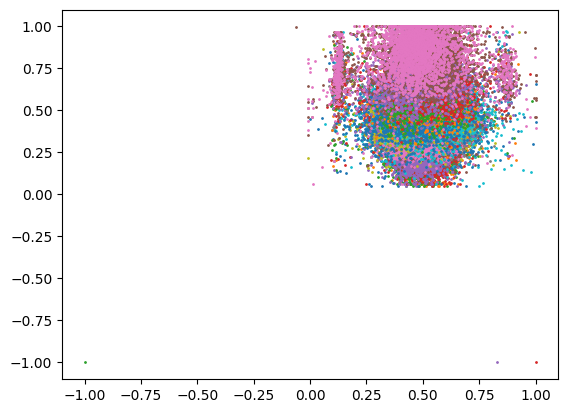

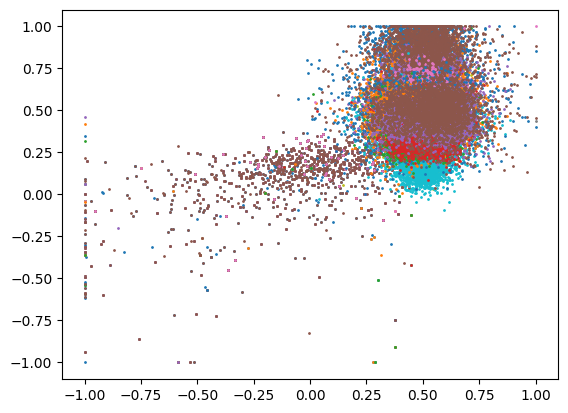

In [44]:
X_test_normalized = normalize(X_test, test_box_center, test_box_scale)
y_test_normalized = normalize(y_test, test_box_center, test_box_scale, scale_px=200*1.25, mask = (y_test!=1))

for i in range(17):
  plt.scatter(np.clip(X_test_normalized[:, i, 0],-1,1),np.clip(X_test_normalized[:, i, 1],-1,1), s=1, vmin=-3, vmax=3)
plt.show()

for i in range(16):
  plt.scatter(np.clip(y_test_normalized[:, i, 0],-1,1),np.clip(y_test_normalized[:, i, 1],-1,1), s=1)
plt.show()

In [45]:
best_model.eval()

with torch.no_grad():
  X_test_normalized = normalize(X_test, test_box_center, test_box_scale)
  X_test_feed_in = torch.tensor(X_test_normalized, dtype=torch.float32).to(device)

  prediction = best_model(X_test_feed_in) 
print("Pred: ", prediction.shape)

Pred:  torch.Size([2958, 16, 2])


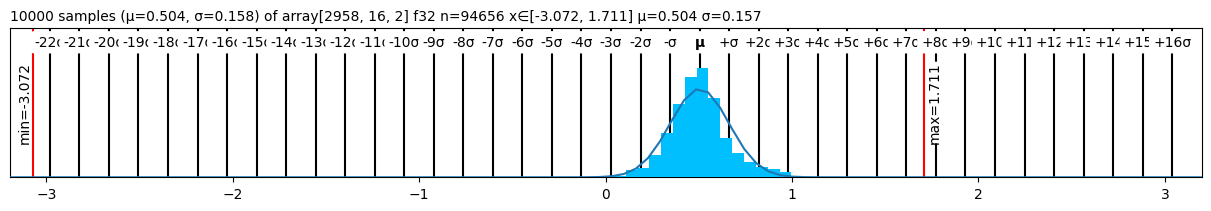

In [53]:
lo(np.array(prediction.cpu())).plt

In [46]:
gt_dict = scipy.io.loadmat(ROOT_FOLDER+'/data/MPII_COCO/annotations/mpii_gt_val.mat')

dataset_joints = gt_dict['dataset_joints']
jnt_missing = gt_dict['jnt_missing']
pos_gt_src = gt_dict['pos_gt_src']
headboxes_src = gt_dict['headboxes_src']

pos_pred_src = unnormalize(prediction.cpu(), 
                           box_center=test_box_center,
                           box_scale=test_box_scale,
                           )
pos_pred_src = np.transpose(pos_pred_src.cpu(), [1, 2, 0])

head = np.where(dataset_joints == 'head')[1][0]
lsho = np.where(dataset_joints == 'lsho')[1][0]
lelb = np.where(dataset_joints == 'lelb')[1][0]
lwri = np.where(dataset_joints == 'lwri')[1][0]
lhip = np.where(dataset_joints == 'lhip')[1][0]
lkne = np.where(dataset_joints == 'lkne')[1][0]
lank = np.where(dataset_joints == 'lank')[1][0]

rsho = np.where(dataset_joints == 'rsho')[1][0]
relb = np.where(dataset_joints == 'relb')[1][0]
rwri = np.where(dataset_joints == 'rwri')[1][0]
rkne = np.where(dataset_joints == 'rkne')[1][0]
rank = np.where(dataset_joints == 'rank')[1][0]
rhip = np.where(dataset_joints == 'rhip')[1][0]

SC_BIAS = 0.6
threshold = 0.5

jnt_visible = 1 - jnt_missing
uv_error = pos_pred_src - pos_gt_src

uv_err = np.linalg.norm(uv_error, axis=1)
headsizes = headboxes_src[1, :, :] - headboxes_src[0, :, :]
headsizes = np.linalg.norm(headsizes, axis=0)
headsizes *= SC_BIAS
scale = headsizes * np.ones((len(uv_err), 1), dtype=np.float32)
scaled_uv_err = uv_err / scale
scaled_uv_err = scaled_uv_err * jnt_visible
jnt_count = np.sum(jnt_visible, axis=1)
less_than_threshold = (scaled_uv_err <= threshold) * jnt_visible
PCKh = 100. * np.sum(less_than_threshold, axis=1) / jnt_count

# save
rng = np.arange(0, 0.5 + 0.01, 0.01)
pckAll = np.zeros((len(rng), 16), dtype=np.float32)

for r, threshold in enumerate(rng):
    less_than_threshold = (scaled_uv_err <= threshold) * jnt_visible
    pckAll[r, :] = 100. * np.sum(
        less_than_threshold, axis=1) / jnt_count

PCKh = np.ma.array(PCKh, mask=False)
print("PCKh Thorax: ", PCKh[6])
print("PCKh Pelvis: ", PCKh[7])
PCKh.mask[6:8] = True

jnt_count = np.ma.array(jnt_count, mask=False)
jnt_count.mask[6:8] = True
jnt_ratio = jnt_count / np.sum(jnt_count).astype(np.float64)

name_value = [('Head', PCKh[head]),
              ('Shoulder', 0.5 * (PCKh[lsho] + PCKh[rsho])),
              ('Elbow', 0.5 * (PCKh[lelb] + PCKh[relb])),
              ('Wrist', 0.5 * (PCKh[lwri] + PCKh[rwri])),
              ('Hip', 0.5 * (PCKh[lhip] + PCKh[rhip])),
              ('Knee', 0.5 * (PCKh[lkne] + PCKh[rkne])),
              ('Ankle', 0.5 * (PCKh[lank] + PCKh[rank])),
              ('Thorax', PCKh[7]),
              ('Pelvis', PCKh[6]),
              ('Upper neck', PCKh[8]),
              ('PCKh', np.sum(PCKh * jnt_ratio)),
              ('PCKh@0.1', np.sum(pckAll[10, :] * jnt_ratio))]
for val in name_value:
    print(f'{val[0]}: {val[1]:.2f}%')




PCKh Thorax:  94.92703266157054
PCKh Pelvis:  98.9768076398363
Head: 94.75%
Shoulder: 97.27%
Elbow: 92.62%
Wrist: 88.50%
Hip: 91.69%
Knee: 90.29%
Ankle: 86.35%
Thorax: --%
Pelvis: --%
Upper neck: 97.34%
PCKh: 92.10%
PCKh@0.1: 32.01%


/tmp/ipykernel_27615/3963776908.py:77: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  print(f'{val[0]}: {val[1]:.2f}%')


In [ ]:
pos_gt_src.shape

(16, 2, 2958)

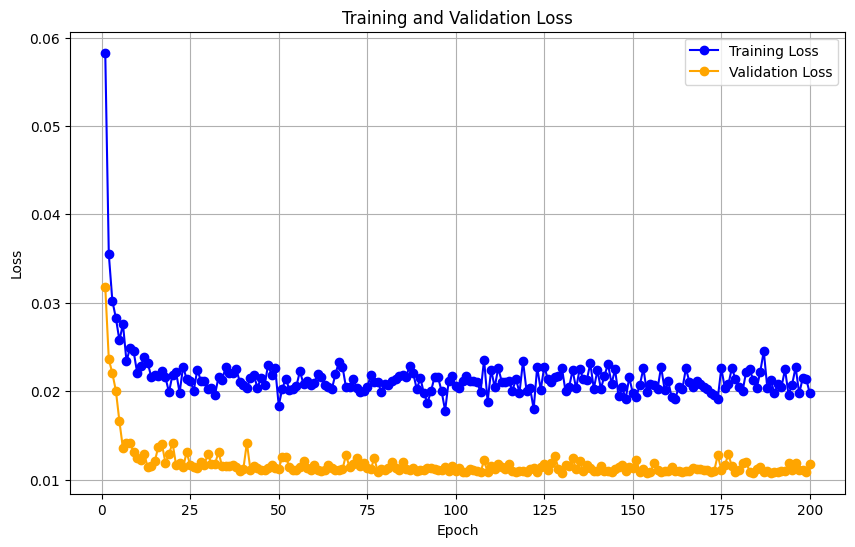

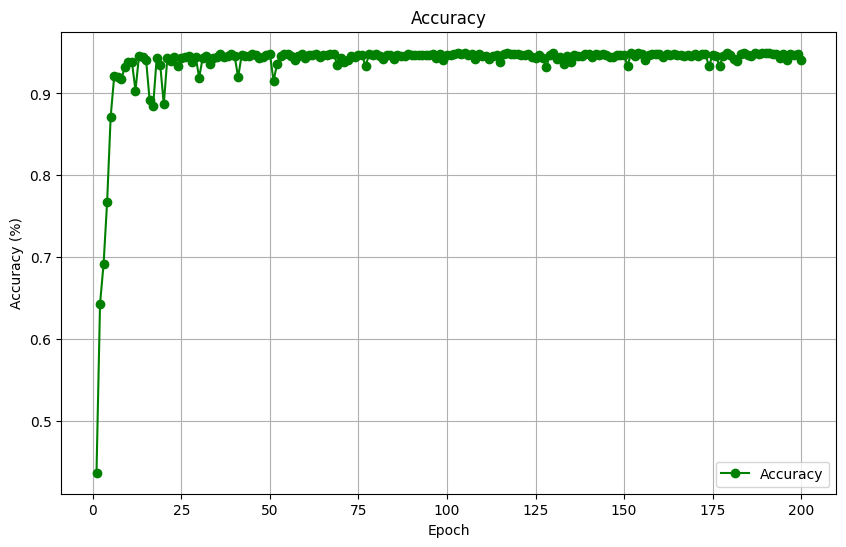

In [47]:
# Training and validation statistics
epochs = [val[0] for val in best_model_logs]
train_losses = [val[1] for val in best_model_logs]
val_losses = [val[2] for val in best_model_logs]
accuracies = [val[3] for val in best_model_logs]

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, label='Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Display some images from translation model

In [48]:
import cv2
from IPython.display import Image, display
from info import MPII_INFO
dataset_info = MPII_INFO()

In [49]:
# dataset_info['skeleton_info']
kps_name2index = {dataset_info['keypoint_info'][key]['name']:key for key in dataset_info['keypoint_info'] }
print(kps_name2index)


{'right_ankle': 0, 'right_knee': 1, 'right_hip': 2, 'left_hip': 3, 'left_knee': 4, 'left_ankle': 5, 'pelvis': 6, 'thorax': 7, 'upper_neck': 8, 'head_top': 9, 'right_wrist': 10, 'right_elbow': 11, 'right_shoulder': 12, 'left_shoulder': 13, 'left_elbow': 14, 'left_wrist': 15}


## Saving some translated images for future references
- green is the prediction and red is the gt

In [52]:
from visualize import save_with_multiple_keypoints
# N x 17 x 2
y_preds_orig = unnormalize(prediction.cpu(), test_box_center, test_box_scale)

index = 0
count = 0


random_numbers = np.random.randint(0, 2958, size=25)

for rand_ind in random_numbers:
   save_with_multiple_keypoints(nth_image=rand_ind,
                           annot_truth=annot_truth_val_set, 
                           path = f'images/coco2mpii/image{annot_truth_val_set[rand_ind]["image"]}',
                           # Green COCO
                           keypoints=X_test[rand_ind],
                           skeleton=None,
                           bounding_box=(annot_truth_val_set[rand_ind]["center"],annot_truth_val_set[rand_ind]["scale"]),
                           # Green
                           keypoints1=y_preds_orig[rand_ind],
                           # Red
                           keypoints2=annot_truth_val_set[rand_ind]["joints"],


                           label1="COCO Pred",
                           label2="COCO->MPII and GT"
                           )



077851429.jpg
bbleft: (861, 28)
bbright: (1200, 367)
086827128.jpg
bbleft: (-330, -510)
bbright: (1050, 870)
020495766.jpg
bbleft: (-460, -400)
bbright: (1182, 1242)
054110292.jpg
bbleft: (309, 56)
bbright: (838, 585)
051329358.jpg
bbleft: (77, 98)
bbright: (290, 311)
010157214.jpg
bbleft: (624, 67)
bbright: (1115, 558)
008703357.jpg
bbleft: (-4, -267)
bbright: (1030, 767)
082119828.jpg
bbleft: (697, 167)
bbright: (1164, 634)
078078785.jpg
bbleft: (916, 353)
bbright: (1435, 872)
024898327.jpg
bbleft: (86, -144)
bbright: (1203, 972)
083962939.jpg
bbleft: (-158, 50)
bbright: (422, 631)
020227318.jpg
bbleft: (1119, 92)
bbright: (1948, 921)
051057041.jpg
bbleft: (208, 29)
bbright: (833, 654)
029870090.jpg
bbleft: (-182, -136)
bbright: (744, 790)
011585278.jpg
bbleft: (-165, -145)
bbright: (707, 727)
063926288.jpg
bbleft: (-166, 92)
bbright: (524, 783)
038371535.jpg
bbleft: (219, -50)
bbright: (582, 312)
067476304.jpg
bbleft: (352, 61)
bbright: (1195, 904)
067582293.jpg
bbleft: (267, 38)
bb

# Try building simple regressors

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])
print("Test instance: ", X_test.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


Train instance:  10531
Val instance:  3511
Test instance:  6018
torch.Size([10531, 17, 2])
torch.Size([10531, 16, 2])
torch.Size([3511, 17, 2])
torch.Size([3511, 16, 2])


In [56]:
from sklearn import linear_model

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_train_stacked = np.reshape(X_train, (X_train.shape[0], -1))
print(X_train_stacked.shape)
X_val_stacked = np.reshape(X_val, (X_val.shape[0], -1))
print(X_val_stacked.shape)
print('y_val: ', y_val.shape)
y_pred = []
for point in range(16):
  y_train_point = y_train[:, point]
  clf_x = linear_model.LinearRegression()
  clf_y = linear_model.LinearRegression()

  clf_x.fit(X_train_stacked, y_train_point[:, 0])
  clf_y.fit(X_train_stacked, y_train_point[:, 1])

  prediction_x = clf_x.predict(X_val_stacked)
  prediction_y = clf_y.predict(X_val_stacked)

  pred = np.stack((prediction_x, prediction_y), axis=1)
  error = ((pred - y_val[:, point]) ** 2).mean(axis = 1)
  # print(error[:10])
  error = np.mean(error)
  y_pred.append(pred)
  print(f'Error {point}: {error}')


(10531, 34)
(3511, 34)
y_val:  (3511, 16, 2)
Error 0: 0.2523927092552185
Error 1: 0.17852628231048584
Error 2: 0.03773608058691025
Error 3: 0.03614656627178192
Error 4: 0.18469898402690887
Error 5: 0.26445436477661133
Error 6: 0.04204677417874336
Error 7: 0.007363406475633383
Error 8: 0.007489797193557024
Error 9: 0.008008081465959549
Error 10: 0.01571737229824066
Error 11: 0.00413608830422163
Error 12: 0.002818225184455514
Error 13: 0.0048429956659674644
Error 14: 0.011921603232622147
Error 15: 0.02785545215010643


In [57]:
y_pred = np.array(y_pred)
y_pred.transpose(1,0,2).shape
# 16 N 2
calculatePCKh(y_pred.transpose(1,0,2), y_val)

0.5774907089765581

## Conclusion
Regressor is not complex enough to learn it.